# Navier-Stokes Forward Simulation

Now let's target a somewhat more complex example: a fluid simulations based on the Navier-Stokes equations. This is still very simple with Φ<sub>Flow</sub>, as differentiable operators for all steps exist. The Navier-Stokes equations (in their incompressible form) introduce an additional pressure field $p$, and a constraint for conservation of mass:

$\begin{align}
    \frac{\partial \mathbf{u}}{\partial{t}} + \mathbf{u} \nabla \mathbf{u} &= - \frac{dt}{\rho} \nabla p + \nu \nabla\cdot \nabla \mathbf{u} + \mathbf{g} \\
    \nabla \cdot \mathbf{u} &= 0 
\end{align}$ 

Here $\mathbf{g}$ collects the forcing terms. Below we'll use a simple buoyancy model. We'll solve this PDE on a closed domain with Dirchlet boundary conditions $\mathbf{u}=0$ for the velocity, and Neumann boundaries $\frac{\partial p}{\partial x}=0$ for pressure, on a domain $\Omega$ with a physical size of $100 \times 80$ units. 

## Implementation

As before, the first command with a "!" prefix installs the [Φ<sub>Flow</sub> Python package from GitHub](https://github.com/tum-pbs/PhiFlow) via `pip` in your python environment. (Skip or modify this command if necessary.)

In [1]:
#!pip install --upgrade --quiet git+https://github.com/tum-pbs/PhiFlow@develop
# [ !pip install --upgrade --quiet phiflow ]
from phi.flow import *  # The Dash GUI is not supported on Google Colab, ignore the warning
import pylab

/Users/thuerey/miniconda3/envs/tf/lib/python3.8/_collections_abc.py:743: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  for key in self._mapping:
/Users/thuerey/miniconda3/envs/tf/lib/python3.8/_collections_abc.py:744: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  yield (key, self._mapping[key])


## Setting up the simulation

Φ<sub>Flow</sub> is object-oriented and centered around field data in the form of grids (internally represented by a tensor object). I.e. you assemble your simulation by constructing a number of grids, and updating them over the course of time steps.

The following code sets up a simulation domain with the physical size, an inflow object to emit a smoke density, and three field: a staggerend `velocity` grid, and two centered grids for the smoke density and a pressure field. We'll use $40\times32$ cells to discretize our domain, introduce a slight viscosity via $\nu$, and define the time step to be $\Delta t=1.5$. 
(As the following variables are constants, they have upper case names.)

In [2]:
DOMAIN = Domain(x=40, y=32, boundaries=CLOSED, bounds=Box[0:100, 0:80])
INFLOW = DOMAIN.grid(Sphere(center=(30, 15), radius=10)) * 0.2

DT = 1.5
NU = 0.01

The inflow will be used to inject smoke into the `smoke` grid. Note that we've defined a `Box` of size $100x80$ above. This is the physical scale in terms of spatial units in our simulation, i.e., a velocity of magnitude $1$ will move the smoke density by 1 unit per 1 time unit, which may be larger or smaller than a cell in the discretized grid, depending on the settings for `x,y`. You could parametrize your simulation grid to directly resemble real-world units, or keep conversion factors in mind for conversion. 

The inflow sphere above is already using the "world" coordinates: it is located at $x=30$ along the first axis, and $y=15$ (within the $100x80$ domain box).

Next, we create grids for the quantities we want to simulate. For this example, we require a velocity field and a smoke density field.
We sample the smoke field at the cell centers and the velocity in [staggered form](https://tum-pbs.github.io/PhiFlow/Staggered_Grids.html).

In [3]:
# velocity = domain.staggered_grid(0)  # alternatively vector_grid(0)
# smoke = pressure = divergence = domain.grid(0)

smoke = DOMAIN.scalar_grid(0)  # sampled at cell centers
velocity = DOMAIN.staggered_grid(0)  # sampled in staggered form at face centers 

Let's define the update step, and plot the marker density after one simulation frame.

Max. velocity and mean density: [0.135354, 0.007865495]


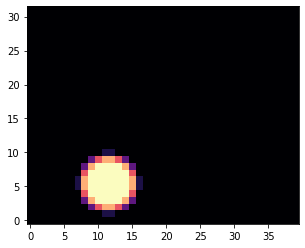

In [4]:
def step(velocity, smoke, pressure, dt=1.0, buoyancy_factor=1.0):
    smoke = advect.semi_lagrangian(smoke, velocity, dt) + INFLOW
    buoyancy_force = smoke * (0, buoyancy_factor) >> velocity  # resamples smoke to velocity sample points
    velocity = advect.semi_lagrangian(velocity, velocity, 1) + dt * buoyancy_force
    velocity = diffuse.explicit(velocity, NU, dt)
    velocity, pressure, iterations, divergence = fluid.make_incompressible(velocity, DOMAIN, pressure_guess=pressure)
    return velocity, smoke, pressure

velocity, smoke, pressure = step(velocity, smoke, None, dt=DT)

print("Max. velocity and mean density: " + format( [ math.max(velocity.values) , math.mean(smoke.values) ] ))

pylab.imshow(np.asarray(smoke.values.numpy('y,x')), origin='lower', cmap='magma')

A lot has happened in this `step()` call: we've advected the smoke field, added an upwards force via a Boussinesq model, advected the velocity field, and finally made it divergence free via a pressure solve.

The Boussinesq model uses a multiplication by a tuple `(0, buoyancy_factor)` to turn the smoke field into a 2 component force field, sampled at the staggered velocity components via the `>>` operator. 

The pressure projection step in `make_incompressible` is typically the computationally most expensive step in the sequence above. It solves a Poisson equation for the boundary conditions of the domain, and updates the velocity field with the gradient of the computed pressure.

Just for testing, we've also printed the mean value of the velocities, and the max density after the update. As you can see in the resulting image, we have a first round region of smoke, with a slight upwards motion (which does not show here yet). 

## Datatypes and Dimensions

The created grids are instances of the class `Grid`.
Like tensors, grids also have the `shape` attribute which lists all batch, spatial and channel dimensions.
[Shapes in Φ<sub>Flow</sub>](https://tum-pbs.github.io/PhiFlow/Math.html#shapes) store not only the sizes of the dimensions but also their names and types.

In [5]:
print(f"Smoke: {smoke.shape}")
print(f"Velocity: {velocity.shape}")
print(f"Inflow: {INFLOW.shape}")
print(f"Inflow, spatial only: {INFLOW.shape.spatial}")



Smoke: (x=40, y=32)
Velocity: (x=40, y=32, vector=2)
Inflow: (x=40, y=32)
Inflow, spatial only: (x=40, y=32)


The grid values can be accessed using the `values` property.

In [6]:
print(smoke.values)
print(velocity.values)
print(INFLOW.values)

(x=40, y=32) float32  0.0 < ... < 0.2
(x=(41, 40) along vector, y=(32, 33) along vector, vector=2) float32  -0.10927753 < ... < 0.135354
(x=40, y=32) float32  0.0 < ... < 0.2


Grids have many more properties which are documented [here](https://tum-pbs.github.io/PhiFlow/phi/field/#phi.field.Grid).
Also note that the staggered grid has a [non-uniform shape](https://tum-pbs.github.io/PhiFlow/Math.html#non-uniform-tensors) because the number of faces is not equal to the number of cells. The `INFLOW` grid naturally has the same dimensions as the `smoke` grid.



## Time Evolution

With this setup, we can easily advance the simulation forward in time a bit more by repeatedly calling the `step` function.

In [7]:
for time_step in range(10):
    velocity, smoke, pressure = step(velocity, smoke, pressure, dt=DT)
    print('Computed frame {}, max velocity {}'.format(time_step , np.asarray(math.max(velocity.values)) ))


Computed frame 0, max velocity 0.40485728
Computed frame 1, max velocity 0.80262446
Computed frame 2, max velocity 1.3215623
Computed frame 3, max velocity 1.99783
Computed frame 4, max velocity 2.8307805
Computed frame 5, max velocity 3.756278
Computed frame 6, max velocity 4.5489845
Computed frame 7, max velocity 5.147038
Computed frame 8, max velocity 5.5985193
Computed frame 9, max velocity 6.0121617


Now the hot plume is starting to rise:

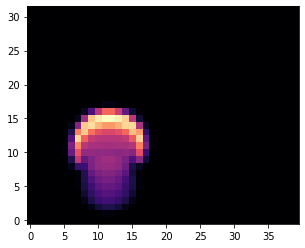

In [8]:
pylab.imshow(smoke.values.numpy('y,x'), origin='lower', cmap='magma')

Let's compute and show a few more steps of the simulation. Because of the inflow being located off-center to the left (with x position 30), the plume will curve towards the right when it hits the top wall of the domain.

Computing time step 0
Computing time step 1
Computing time step 2
Computing time step 10


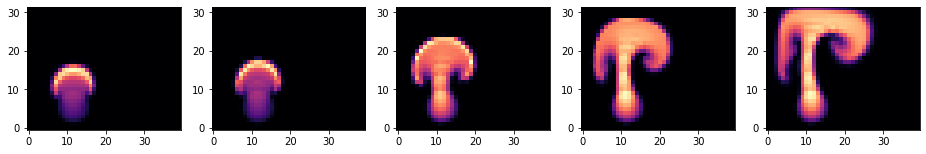

In [9]:
steps = [smoke.values.numpy('y,x')]
for time_step in range(20):
  if time_step<3 or time_step%10==0: 
    print('Computing time step %d' % time_step)
  velocity, smoke, pressure = step(velocity, smoke, pressure, dt=DT)
  if time_step%5==0:
    steps.append(smoke.values.numpy('y,x'))

fig, axes = pylab.subplots(1, len(steps), figsize=(16, 5))
for i in range(len(steps)):
  axes[i].imshow(steps[i], origin='lower', cmap='magma')

It looks simple here, but this simulation setup is a powerful tool. The simulation could easily be extended to more complex cases or 3D, and they're fully compatible with back-propagation pipelines of deep learning frameworks. 

In the next chapters we'll show how to use these simulations for training NNs, and how to steer and modify them via trained NNs. This will illustrate how much we can improve the training process by having a solver in the loop, and especially by having differentiable solvers.